# Overview
### This project implements Long Short-Term Memory (LSTM) models for predicting stock prices using historical data fetched from Yahoo Finance. The code preprocesses the data, trains LSTM models, evaluates their performance, and visualizes the results. It focuses on four stock symbols: Apple (AAPL), Nvidia (NVDA), Google (GOOGL), and Amazon (AMZN).

**Long Short-Term Memory (LSTM)** models have emerged as a cornerstone in the realm of stock market prediction, capitalizing on their capacity to discern temporal intricacies and process sequential data with remarkable efficacy. By delving into historical stock price data and harnessing sophisticated architectural designs, LSTM models furnish invaluable prognostications regarding future price dynamics, furnishing investors and analysts with discerning insights pivotal for informed decision-making within the convoluted landscape of financial markets. Persistent scholarly inquiry and innovation within this domain harbor the promise of augmenting the prognosticative prowess of LSTM models, potentially heralding a paradigm shift in the comprehension and scrutiny of stock market conduct.

**Application in Stock Market Prediction:**
In the sphere of stock market prediction, LSTM models find application in the dissection of historical stock price datasets to prognosticate forthcoming price fluctuations. This deployment capitalizes on the intrinsic sequential nature of stock market data, wherein each datum embodies a temporal snapshot of market behavior. By immersing in historical stock price sequences, LSTM models acquaint themselves with underlying patterns and trends that wield influence over future price trajectories.

**Advantages and Challenges:**
LSTM models proffer manifold advantages for stock market prognostication, encompassing their adeptness in capturing prolonged temporal dependencies, adept handling of sequential data, and adaptability to evolving market dynamics. Nevertheless, an array of challenges besets their efficacy, spanning from the specter of overfitting and the specter of data paucity to the inherent caprice pervading financial markets. The scholarly community perseveres in its quest to devise innovative stratagems aimed at surmounting these hurdles and refining the performance of LSTM models in the domain of stock market prediction.

## Importing necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import LSTM, Dense
import yfinance as yf
from tqdm import tqdm
import seaborn as sns

## Global variables

1. **SYMBOLS**: This variable is a list containing the stock symbols for the companies of interest, namely Apple (AAPL), Nvidia (NVDA), Google (GOOGL), and Amazon (AMZN). These symbols represent the entities for which the stock price data will be fetched and analyzed.

2. **START_DATE**: It specifies the starting date for fetching historical stock price data. In this case, the date is set to '2022-01-01', indicating the beginning of the time period from which the data will be collected.

3. **END_DATE**: This variable denotes the ending date for fetching historical stock price data. The date '2024-01-01' signifies the conclusion of the time period for data collection.

4. **LOOK_BACK**: It determines the number of previous time steps to consider when creating input-output pairs for training the LSTM model. A value of 3 implies that the model will utilize data from the past three time steps to make predictions for the next time step.

5. **EPOCHS**: This variable specifies the number of epochs, i.e., the number of iterations over the entire training dataset, during model training. In this case, the model will undergo 1000 epochs, allowing it to learn from the data and refine its predictive capabilities over multiple iterations.

In [3]:
SYMBOLS = ['AAPL', 'NVDA', 'GOOGL', 'AMZN']  # Stock symbols (Apple, Nvidia, Google, Amazon)
START_DATE = '2022-01-01'
END_DATE = '2024-01-01'
LOOK_BACK = 3
EPOCHS = 1000

## Fetching stock price data from Yahoo Finance

In [4]:
# Fetching stock price data from Yahoo Finance
def fetch_stock_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    return data

## Step 1: Data Preparation
### Adjusted Close Prices Selection:
- The line of code `adj_close = data['Adj Close'].values.reshape(-1,1)` extracts the 'Adj Close' prices from the input dataset. In financial markets, the adjusted closing price accounts for various corporate actions like dividends, stock splits, and mergers. It serves as a crucial indicator of a stock's performance over time.

#### Data Normalization:
- Following the selection of 'Adj Close' prices, the data undergoes normalization using the MinMaxScaler technique. Normalization is a standard preprocessing step in machine learning, particularly for neural networks. It transforms the data to a predefined range, often between 0 and 1 in this case, to enhance model performance and stability. Mathematically, the MinMaxScaler formula is:

- MinMaxScaler is a common normalization technique used in machine learning to scale features to a fixed range, typically between 0 and 1. It transforms the data linearly, preserving the original distribution while ensuring consistency in scale across features.

#### Train-Test Data Split:
- After normalization, the dataset is divided into training and testing subsets. Typically, around 80% of the data is allocated for training (`train_size`), while the remaining 20% is reserved for testing (`test_size`). This partitioning allows the model to learn patterns from the training data and evaluate its performance on unseen test data, facilitating the assessment of its generalization capability.

#### Returning Training Data, Test Data, and Scaler:
- The function concludes by returning the training data, test data, and the scaler object utilized for normalization. These components play vital roles in subsequent stages of the machine learning workflow, such as model training, evaluation, and prediction.

#### Relevant Studies and Theories:
- Data normalization, train-test splitting, and the usage of MinMaxScaler are extensively covered in machine learning literature:

- The concept of data normalization is elaborated upon in "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron, particularly in Chapter 2, where the importance of feature scaling and its impact on machine learning algorithms are discussed.
  
- Train-test splitting is a fundamental practice in machine learning elucidated in "Introduction to Machine Learning with Python" by Andreas C. Müller and Sarah Guido. This approach is crucial for assessing model performance and ensuring its ability to generalize to new data.

- The MinMaxScaler technique is part of the scikit-learn library, documented extensively in scikit-learn's official documentation. This scaler, along with other preprocessing tools, aids in preparing data for machine learning tasks.

https://www.datacamp.com/tutorial/normalization-in-machine-learning
https://www.geeksforgeeks.org/what-is-data-normalization/

In [5]:
# Step 1: Data Preparation
def prepare_data(data):
    # Selecting Adjusted Close prices
    adj_close = data['Adj Close'].values.reshape(-1,1)

    # Normalizing the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    adj_close_normalized = scaler.fit_transform(adj_close)

    # Splitting data into train and test sets
    train_size = int(len(adj_close_normalized) * 0.80)
    test_size = len(adj_close_normalized) - train_size
    train_data, test_data = adj_close_normalized[0:train_size,:], adj_close_normalized[train_size:len(adj_close_normalized),:]

    return train_data, test_data, scaler

### Creating dataset with look-back

- This method prepares the data by organizing it into input-output pairs suitable for training an LSTM model, enabling the model to learn temporal patterns and make predictions based on historical sequences of stock price data.

In [6]:
# Creating dataset with look-back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

## Step 2: Model Training

- This method encapsulates the entire process of training an LSTM model for sequential data prediction, including data preparation, model architecture definition, training, and model retrieval.

#### Data Preparation:
- **Input Data**: The training data `train_data` is a numpy array containing the historical stock prices.
- **Input-Output Pairs**: The `create_dataset` function is used to create input-output pairs from the training data. Each input sequence consists of `look_back` previous time steps, and the corresponding output is the next time step's value.

#### Data Reshaping:
- The input data (`X_train`) is reshaped to match the input shape expected by the LSTM model. LSTM layers in Keras expect input data in the shape `(samples, time steps, features)`, where:
  - `samples` is the number of data points,
  - `time steps` is the number of time steps in each input sequence (determined by `look_back`), and
  - `features` is the number of features at each time step (in this case, 1 for the stock price).

#### LSTM Model Architecture:
- **LSTM Layer**: An LSTM layer with 4 units (neurons) is added to the model. The input shape is specified based on the `look_back` parameter, indicating the number of previous time steps to consider for prediction.
- **Dense Layer**: A dense (fully connected) output layer with 1 unit is added to predict the next value in the sequence.
- **Compilation**: The model is compiled using mean squared error (MSE) as the loss function and the Adam optimizer.

#### Model Training:
- The model is trained using the training data in a loop over a specified number of epochs.
- Within each epoch, the `fit` method is called with a batch size of 1 (online learning) to update the model's weights based on the current batch of training data.
- The training progress is monitored using a tqdm progress bar, displaying the epoch number and the current loss value.

#### Return Model:
- Once training is complete, the trained LSTM model is returned from the method for further evaluation and use.

In [7]:
# Step 2: Model Training
def train_lstm(train_data, look_back=1, epochs=100):
    X_train, Y_train = create_dataset(train_data, look_back)
    
    # Reshape input data to match LSTM input shape
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Building LSTM model
    model = Sequential()
    model.add(LSTM(4, input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Training the model
    epoch_range = tqdm(range(epochs), desc="Epochs")
    for epoch in epoch_range:
        model.fit(X_train, Y_train, epochs=1, batch_size=1, verbose=0)
        epoch_range.set_postfix({'loss': model.history.history['loss'][0]})
    
    return model

## Step 3: Result Visualization

In [8]:
# Step 3: Result Visualization
def visualize_results(data, scaler, model, stock_symbol, look_back=1):
    # Print shapes for debugging
    print("Data Shape:", data.shape)
    print("Model Input Shape:", model.input_shape)
    
    # Reshape the data for prediction
    data = data.reshape(-1, 1, 1)
    
    # Making predictions
    train_predict = model.predict(data)
    train_predict = scaler.inverse_transform(train_predict)
    
    # Setting seaborn style
    sns.set_style("whitegrid")
    
    # Plotting results with stock symbol in legend
    plt.figure(figsize=(10, 6))
    plt.plot(scaler.inverse_transform(data.reshape(-1, 1)), label=f'Actual ({stock_symbol})', color='blue', alpha=0.6, linewidth=2)
    plt.plot(train_predict, label=f'Predicted ({stock_symbol})', color='orange', alpha=0.8, linewidth=2)
    plt.title(f'Predicted vs Actual Stock Prices ({stock_symbol})', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Stock Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


## Step 4: Performance Evaluation

- These metrics provide valuable insights into the performance of regression models to evaluate the accuracy, precision, and overall goodness-of-fit like of this LSTM prediction

1. **Mean Absolute Error (MAE)**:
   - MAE measures the average absolute errors between predicted values and actual values.
   - Mathematically, it is calculated as the average of the absolute differences between the predicted values (\( \hat{y_i} \)) and the actual values (\( y_i \)):
     \[ MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y_i}| \]
   - MAE provides a straightforward interpretation because it's in the same unit as the target variable.
2. **Mean Squared Error (MSE)**:
   - MSE measures the average squared differences between predicted values and actual values.
   - It is calculated as the average of the squared differences between the predicted values and the actual values:
     \[ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y_i})^2 \]
   - MSE penalizes large errors more than MAE, making it sensitive to outliers.
3. **R-squared (R2)**:
   - R-squared indicates the proportion of the variance in the dependent variable (target) that is predictable from the independent variable (features).
   - It ranges from 0 to 1, where 1 indicates a perfect fit and 0 indicates no linear relationship between the independent and dependent variables.
   - Mathematically, it is calculated as:
     \[ R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y_i})^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} \]
     where \( \bar{y} \) is the mean of the actual values.
   - R-squared can be interpreted as the proportion of the total variation in the dependent variable that is explained by the independent variable.
4. **Mean Absolute Percentage Error (MAPE)**:
   - MAPE measures the percentage difference between predicted values and actual values.
   - It is calculated as the mean of the absolute percentage errors:
     \[ MAPE = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y_i}}{y_i} \right| \times 100 \]
   - MAPE is useful for understanding the size of the errors relative to the actual values.

In [9]:
def evaluate_performance(model, test_data, scaler, look_back=1):
    X_test, Y_test = create_dataset(test_data, look_back)
    
    # Reshape input data to match LSTM input shape
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # Making predictions
    test_predict = model.predict(X_test)
    test_predict = scaler.inverse_transform(test_predict)
    
    # Reshape Y_test to match the shape of test_predict
    Y_test = Y_test.reshape(test_predict.shape)
    
    # Calculating performance metrics
    rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
    mae = mean_absolute_error(Y_test, test_predict)
    mape = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100
    r2 = r2_score(Y_test, test_predict)
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"R-squared: {r2}")

## Main function

- The `main` function manages the LSTM model execution for each stock symbol provided. It iterates over each symbol, fetching historical stock price data using `fetch_stock_data` and preparing it with `prepare_data`, which involves selecting relevant features, normalizing the data, and splitting it into training and testing sets. 
- The prepared training data is then used to train the LSTM model through `train_lstm`, specifying parameters such as the look-back period and epochs. After training, the model's performance is assessed using `evaluate_performance`, which calculates metrics like RMSE, MAE, MAPE, and R-squared. 
- These metrics quantify the accuracy of the predictions made by the model. Subsequently, the results are visualized with `visualize_results`, plotting the actual and predicted stock prices for the training data. 
- This process repeats for each symbol in the provided list. 

[*********************100%%**********************]  1 of 1 completed
Epochs: 100%|█████████████████| 1000/1000 [03:51<00:00,  4.32it/s, loss=0.00167]


4/4 [==============================] - 1s 4ms/step
RMSE: 181.20895785108198
MAE: 181.01561180402663
MAPE: 23503.940268503742
R-squared: -2490391.20891591
Data Shape: (400, 1)
Model Input Shape: (None, 3, 1)
13/13 [==============================] - 0s 498us/step


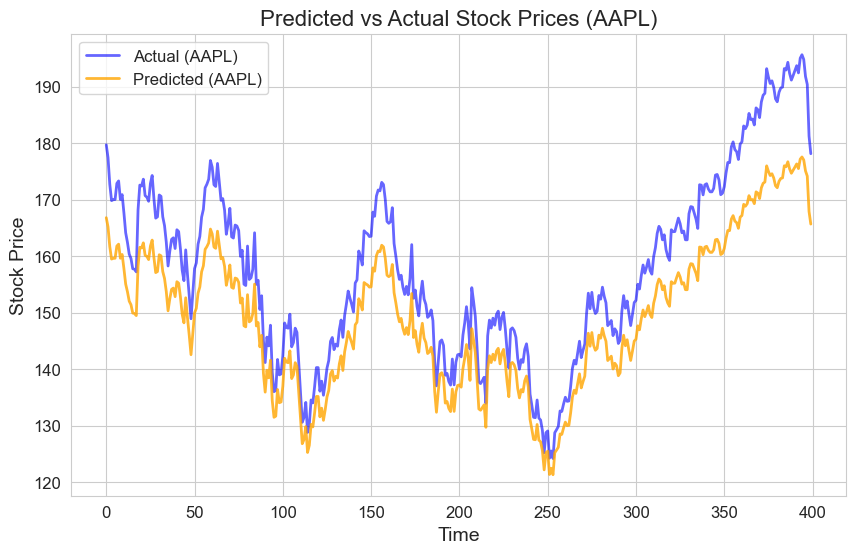

[*********************100%%**********************]  1 of 1 completed
Epochs: 100%|████████████████| 1000/1000 [03:54<00:00,  4.27it/s, loss=0.000515]

4/4 [==============================] - 0s 814us/step


RMSE: 456.7868312119235
MAE: 456.21597019252914
MAPE: 51836.617304964806
R-squared: -44393754.54969022
Data Shape: (400, 1)
Model Input Shape: (None, 3, 1)
13/13 [==============================] - 0s 479us/step


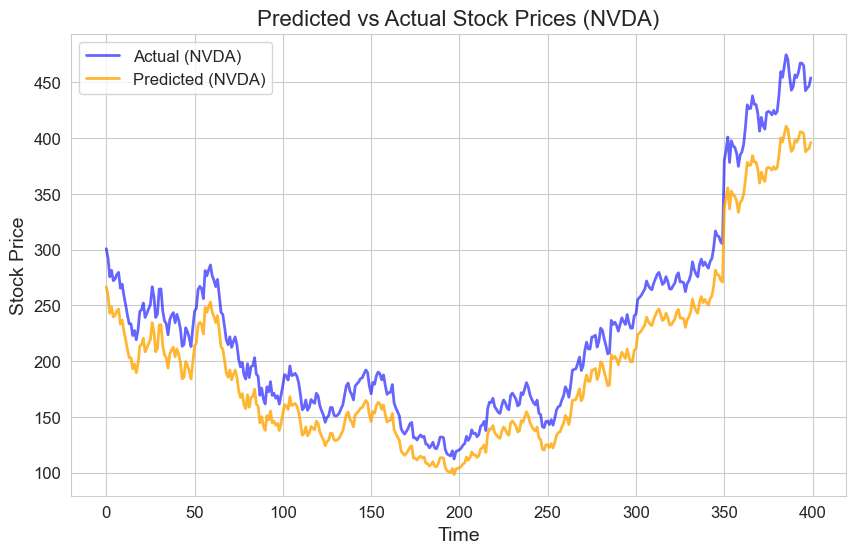

[*********************100%%**********************]  1 of 1 completed
Epochs: 100%|██████████████████| 1000/1000 [03:51<00:00,  4.32it/s, loss=0.0016]

1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 966us/step
RMSE: 132.59260722030663
MAE: 132.53255669604567
MAPE: 17095.035148947416
R-squared: -3977235.70547165
Data Shape: (400, 1)
Model Input Shape: (None, 3, 1)
13/13 [==============================] - 0s 533us/step


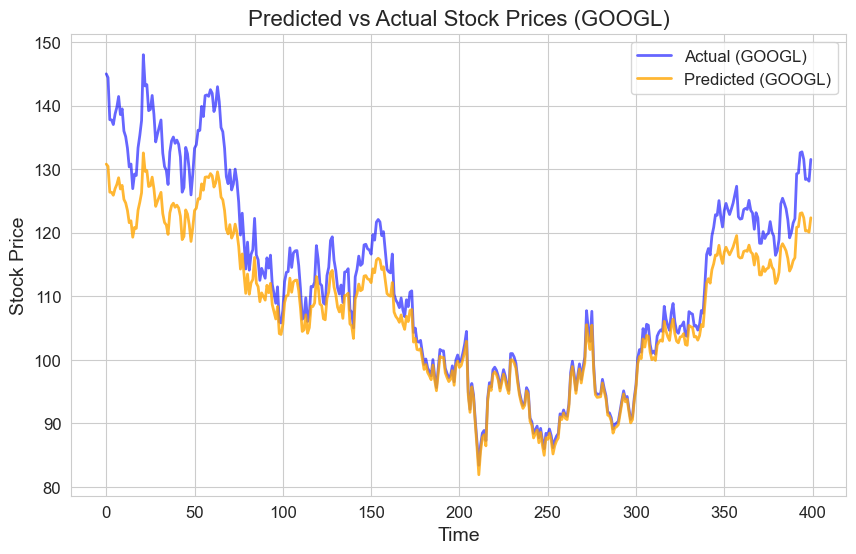

[*********************100%%**********************]  1 of 1 completed
Epochs: 100%|█████████████████| 1000/1000 [03:55<00:00,  4.25it/s, loss=0.00159]

4/4 [==============================] - 0s 1ms/step


RMSE: 136.11967654406004
MAE: 135.8773910576898
MAPE: 21619.61242137456
R-squared: -1993405.6949866728
Data Shape: (400, 1)
Model Input Shape: (None, 3, 1)
13/13 [==============================] - 0s 450us/step


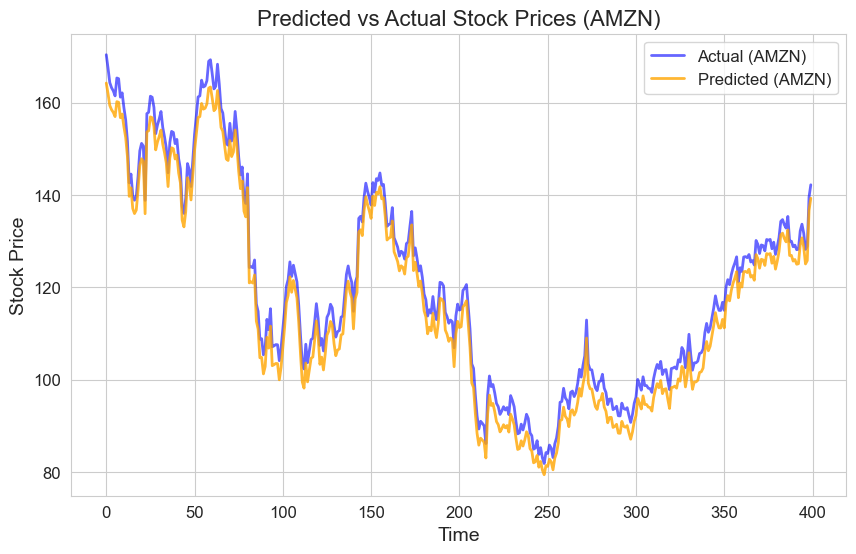

In [10]:
def main():
    for symbol in SYMBOLS:
        # Fetching and preparing data
        data = fetch_stock_data(symbol, START_DATE, END_DATE)
        train_data, test_data, scaler = prepare_data(data)
        
        # Training LSTM model
        lstm_model = train_lstm(train_data, LOOK_BACK, EPOCHS)
        
        # Evaluating performance
        evaluate_performance(lstm_model, test_data, scaler, LOOK_BACK)
        
        # Visualizing results with stock symbol
        visualize_results(train_data, scaler, lstm_model, symbol, LOOK_BACK)

if __name__ == "__main__":
    main()